In [ ]:
import pandas as pd
from fbprophet import Prophet

In [ ]:
df_customer = pd.read_csv('olist_customers_dataset.csv')
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
df_order_items = pd.read_csv('olist_order_items_dataset.csv')
df_order_payments = pd.read_csv('olist_order_payments_dataset.csv')
df_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_products = pd.read_csv('olist_products_dataset.csv')
df_sellers = pd.read_csv('olist_sellers_dataset.csv')
df_category_name = pd.read_csv('product_category_name_translation.csv')

In [ ]:
# Script para juntar as bases
df = df_orders.merge(df_order_items, on='order_id', how='left')
df = df.merge(df_order_payments, on='order_id', how='outer', validate='m:m')
df = df.merge(df_order_reviews, on='order_id', how='outer')
df = df.merge(df_products, on='product_id', how='outer')
df = df.merge(df_customer, on='customer_id', how='outer')
df = df.merge(df_sellers, on='seller_id', how='outer')

In [ ]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,1.0,credit_card,3.0,37.77,b46f1e34512b0f4c74a72398b03ca788,4.0,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,1.0,credit_card,1.0,37.77,dc90f19c2806f1abba9e72ad3c350073,5.0,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP


# Previsão de vendas considerando todas as regiões

In [ ]:
from fbprophet import Prophet

In [ ]:
#Convertendo o campo de data para timestamp e depois criando o dataframe para treinar o modelo
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp']).dt.date
df1 = df.groupby('order_purchase_timestamp')['product_id'].count().reset_index()

In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly

In [ ]:
#pega a quantidade de linhas e subistitui por 190 (é ~30% do universo de 634)
split_point = len(df1)-190

In [ ]:
#define que a variavel df_model_2 vai conter linhas até o split point
df_model = df1[0:split_point]

In [ ]:
#define que a variavel validation terá os dados do split_point em diante
validation = df1[split_point:]

In [ ]:
#imprime o tamanho dos conjuntos
print('Dataset %d, Validation %d' % (len(df_model), len(validation)))

Dataset 444, Validation 190


In [ ]:
#necessário alterar o nome das colunas para 'ds' tipo de data para o modelo e y que pode ser a soma de vendas por exemplo
df_model = df_model[['order_purchase_timestamp', 'product_id']].rename(columns = {'order_purchase_timestamp': 'ds', 'product_id': 'y'})
validation = validation[['order_purchase_timestamp', 'product_id']].rename(columns = {'order_purchase_timestamp': 'ds', 'product_id': 'y'})

In [ ]:
#dataset validation
df_validation = pd.DataFrame({'ds': validation['ds']})

In [ ]:
#instacia o objeto prophet
model = Prophet()

In [ ]:
#gerando o modelo
model.fit(df_model)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#aplicando o modelo prophet
saida = model.predict(df_validation)

In [ ]:
#imprime as saidas
saida[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-03-10,265.068866,175.667719,368.638352
1,2018-03-11,273.393369,183.860940,367.893060
2,2018-03-12,321.649468,227.252793,421.897433
3,2018-03-13,325.802170,233.751027,429.393376
4,2018-03-14,316.530188,212.933789,414.275205
...,...,...,...,...
185,2018-09-29,394.565020,299.007888,494.548167
186,2018-10-01,451.145621,352.683084,548.951386
187,2018-10-03,446.026341,345.312745,540.422610
188,2018-10-16,464.229092,368.519845,560.145450


In [ ]:
validation

,ds,y
444,2018-03-10,219
445,2018-03-11,246
446,2018-03-12,267
447,2018-03-13,279
448,2018-03-14,243
...,...,...
629,2018-09-29,0
630,2018-10-01,0
631,2018-10-03,0
632,2018-10-16,0


In [ ]:
#Avaliando os resultados
#O RMSE quer dizer que o modelo na previsão que ele faz pode errar 180 vendas pra cima ou pra baixo
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(validation['y'], saida.yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 180.156


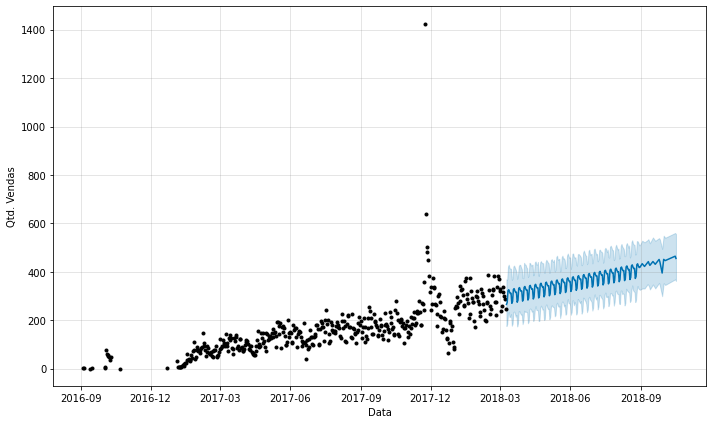

In [ ]:
figura = model.plot(saida, xlabel = 'Data', ylabel = 'Qtd. Vendas');

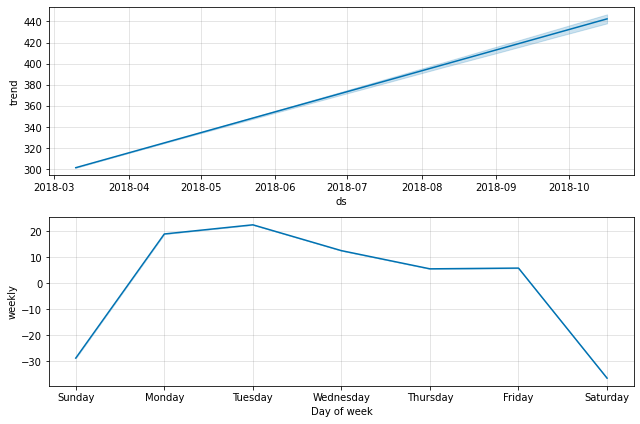

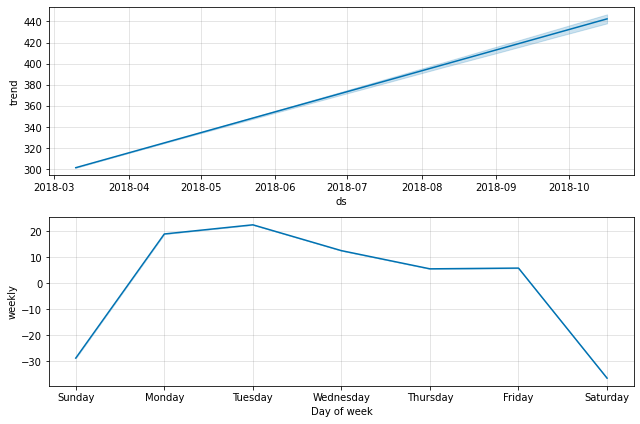

In [ ]:
model.plot_components(saida)

In [ ]:
#Após treinar e validar o modelo, foi gerado uma previsão das vendas para os próximos anos
future = model.make_future_dataframe(periods=35, freq='M')  
forecast = model.predict(future)

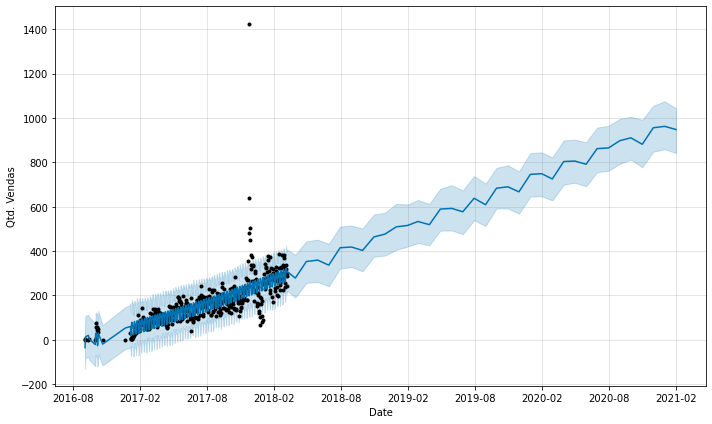

In [ ]:
#Plotando a previsão
model.plot(forecast, xlabel = 'Date', ylabel = 'Qtd. Vendas');

## Previsão de vendas da região norte e nordeste

In [ ]:
#Função para criar a feature de região
def transformar_estado(valor):
    if valor == 'AC':
        return 'Norte'
    elif valor == 'AP':
        return 'Norte'
    elif valor == 'AM':
        return 'Norte'
    elif valor == 'PA':
        return 'Norte'
    elif valor == 'RO':
        return 'Norte'
    elif valor == 'RR':
        return 'Norte'
    elif valor == 'TO':
        return 'Norte'
    elif valor == 'AL':
        return 'Nordeste'
    elif valor == 'BA':
        return 'Nordeste'
    elif valor == 'CE':
        return 'Nordeste'
    elif valor == 'MA':
        return 'Nordeste'
    elif valor == 'PB':
        return 'Nordeste'
    elif valor == 'PE':
        return 'Nordeste'
    elif valor == 'PI':
        return 'Nordeste'
    elif valor == 'RN':
        return 'Nordeste'
    elif valor == 'SE':
        return 'Nordeste'  
    elif valor == 'DF':
        return 'Centro-Oeste'
    elif valor == 'GO':
        return 'Centro-Oeste'
    elif valor == 'MT':
        return 'Centro-Oeste'
    elif valor == 'MS':
        return 'Centro-Oeste'
    elif valor == 'ES':
        return 'Sudeste'
    elif valor == 'RJ':
        return 'Sudeste'
    elif valor == 'MG':
        return 'Sudeste'
    elif valor == 'SP':
        return 'Sudeste'
    else:
        return 'Sul'

In [ ]:
df['customer_region'] = df['customer_state'].map(transformar_estado)
df['seller_region'] = df['seller_state'].map(transformar_estado)

In [ ]:
df_region_1 = df[(df['customer_region'] == 'Nordeste') | (df['customer_region'] == 'Norte') | (df['customer_region'] == 'Centro-Oeste')]

In [ ]:
#Convertendo o campo de data para timestamp e depois criando o dataframe para treinar o modelo
df_region_1['order_purchase_timestamp'] = pd.to_datetime(df_region_1['order_purchase_timestamp']).dt.date
df_region = df_region_1.groupby('order_purchase_timestamp')['product_id'].count().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
len(df_region)

606

In [ ]:
#pega a quantidade de linhas e subistitui por 180 (é ~30% do universo de 603)
split_point = len(df_region)-180

In [ ]:
#define que a variavel df_model_2 vai conter linhas até o split point
df_model_region = df_region[0:split_point]

In [ ]:
#define que a variavel validation terá os dados do split_point em diante
validation_region = df_region[split_point:]

In [ ]:
#imprime o tamanho dos conjuntos
print('Dataset %d, Validation %d' % (len(df_model_region), len(validation)))

Dataset 426, Validation 190


In [ ]:
#necessário alterar o nome das colunas para 'ds' tipo de data para o modelo e y que pode ser a soma de vendas por exemplo
df_model_region = df_model_region[['order_purchase_timestamp', 'product_id']].rename(columns = {'order_purchase_timestamp': 'ds', 'product_id': 'y'})
validation_region = validation_region[['order_purchase_timestamp', 'product_id']].rename(columns = {'order_purchase_timestamp': 'ds', 'product_id': 'y'})

In [ ]:
#dataset validation
df_validation = pd.DataFrame({'ds': validation_region['ds']})

In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly

In [ ]:
#instacia o objeto prophet
model = Prophet()

In [ ]:
#gerando o modelo
model.fit(df_model_region)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#aplicando o modelo prophet
saida = model.predict(df_validation)

In [ ]:
#Avaliando os resultados
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(validation_region['y'], saida.yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 23.884


O RMSE para a região centro-oeste, norte e nordeste ficou bom, pois o modelo pode errar 23 vendas pra cima ou pra baixo

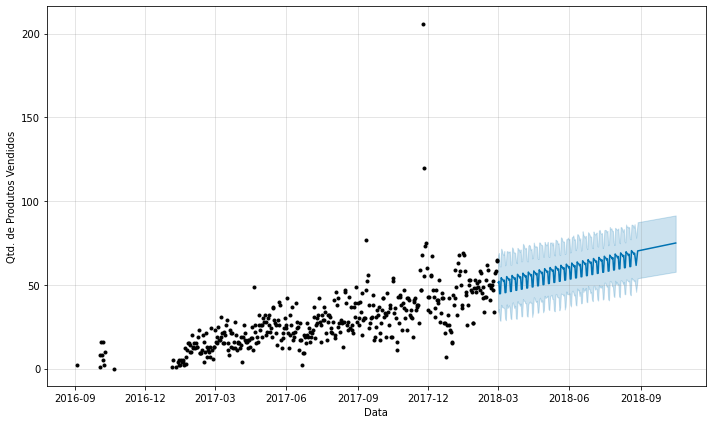

In [ ]:
#Plotando o modelo treinado
figura = model.plot(saida, xlabel = 'Data', ylabel = 'Qtd. de Produtos Vendidos');

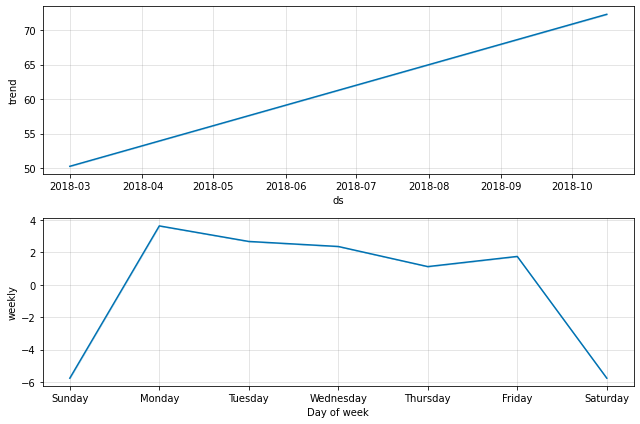

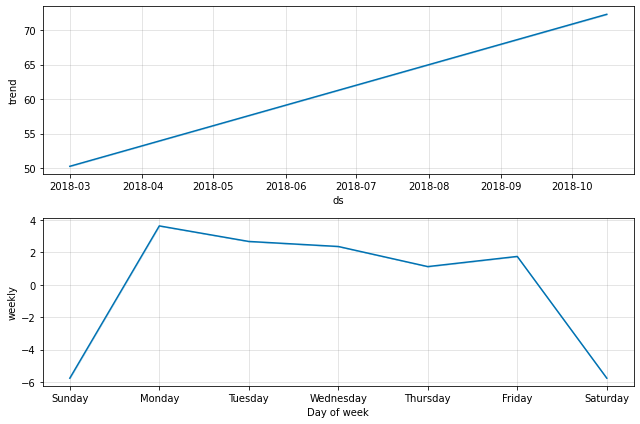

In [ ]:
model.plot_components(saida)

In [ ]:
future = model.make_future_dataframe(periods=35, freq='M')  
forecast = model.predict(future)

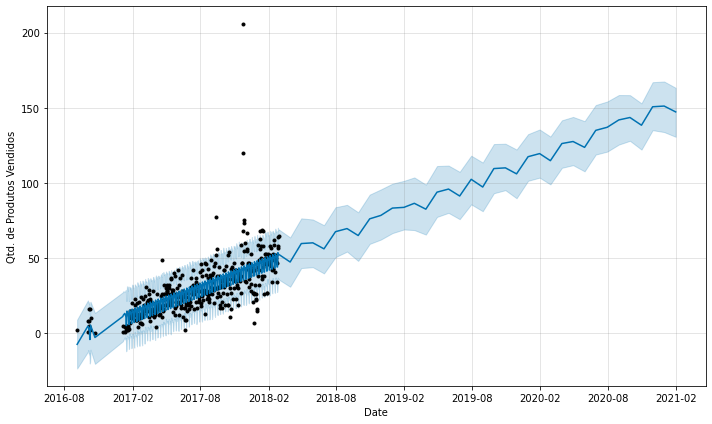

In [ ]:
model.plot(forecast, xlabel = 'Date', ylabel = 'Qtd. de Produtos Vendidos');

# Salvar o modelo treinado

In [ ]:
import pickle

In [ ]:
#@title Texto de título padrão
DATA_PATH = "/content/drive/MyDrive"

In [ ]:
with open(DATA_PATH+"test.pickle", 'rb') as f:
     pickle.dump(model, f)

FileNotFoundError: ignored